In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Fetch historical price data from Yahoo Finance API
def fetch_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    # Calculate Moving Averages (50-day and 200-day)
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data)

    # Calculate MACD and Signal Line
    data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    return data

# Calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define your strategy conditions
def strategy(data, stop_loss_pct=0.15, take_profit_pct=0.25):
    # Initialize lists for buy and sell signals with NaN values
    buy_signals = [np.nan]
    sell_signals = [np.nan]
    # Initialize columns for stop-loss and take-profit
    data['Max_Close'] = data['Close'].cummax()  # Track the maximum closing value reached
    data['Min_Close'] = data['Close'].cummin()  # Track the minimum closing value reached
    data['Stop_Loss'] = data['Max_Close'] * (1 - stop_loss_pct)  # Define stop loss level
    data['Take_Profit'] = data['Min_Close'] * (1 + take_profit_pct)  # Define take profit level

    # Initialize position as a column with all zeros
    data['Position'] = 0

    # Iterate through data for position determination
    for i in range(1, len(data)):
        if data['MA50'].iloc[i] > data['MA200'].iloc[i] and data['MACD'].iloc[i] > data['Signal_Line'].iloc[i] and data['RSI'].iloc[i] < 70:
            data.at[data.index[i], 'Position'] = 1
        elif (data['MA50'].iloc[i] < data['MA200'].iloc[i] or data['MACD'].iloc[i] < data['Signal_Line'].iloc[i]) or data['Close'].iloc[i] < data['Stop_Loss'].iloc[i] or data['Close'].iloc[i] > data['Take_Profit'].iloc[i]:
            data.at[data.index[i], 'Position'] = 0
        else:
            # Carry forward the previous position if no condition is met
            data.at[data.index[i], 'Position'] = data['Position'].iloc[i-1]
            
    for i in range(1, len(data)):
        # Golden Cross and MACD Bullish
        if data['MA50'].iloc[i] > data['MA200'].iloc[i] and data['MACD'].iloc[i] > data['Signal_Line'].iloc[i]:
            if data['RSI'].iloc[i] < 70:  # Avoid overbought
                buy_signals.append(data['Close'].iloc[i])
                sell_signals.append(np.nan)
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        # Death Cross and MACD Bearish
        elif data['MA50'].iloc[i] < data['MA200'].iloc[i] and data['MACD'].iloc[i] < data['Signal_Line'].iloc[i]:
            if data['RSI'].iloc[i] > 30 or ():  # Avoid oversold
                sell_signals.append(data['Close'].iloc[i])
                buy_signals.append(np.nan)
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    # Calculate Strategy Returns
    data['Strategy_Return'] = data['Close'].pct_change() * data['Position'].shift(1)
    return data

def portfolio(portfolio_tickers, start_date, end_date): 
    # Fetch and apply strategy to each stock in the portfolio
    portfolio_data = {}
    for ticker in portfolio_tickers:
        stock_data = fetch_historical_data(ticker, start_date, end_date)
        stock_data = strategy(stock_data)
        portfolio_data[ticker] = stock_data

    # Combine the individual strategy returns into a portfolio
    portfolio_return = pd.DataFrame()
    for ticker, data in portfolio_data.items():
        portfolio_return[ticker] = data['Strategy_Return']

    # Assuming equal weighting for simplicity
    portfolio_return['Total'] = portfolio_return.mean(axis=1)

    # Calculate cumulative returns
    portfolio_return['Cumulative'] = (1 + portfolio_return['Total']).cumprod()
    return portfolio_return

[*********************100%%**********************]  1 of 1 completed


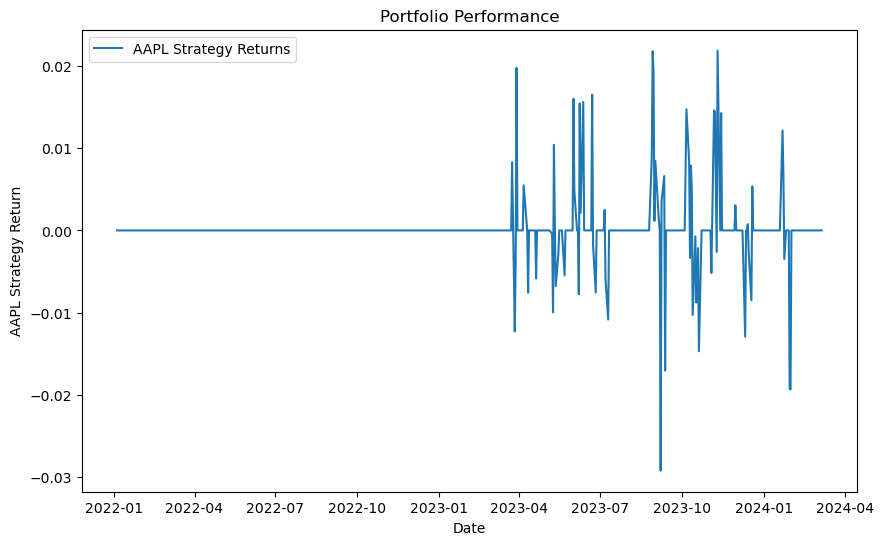

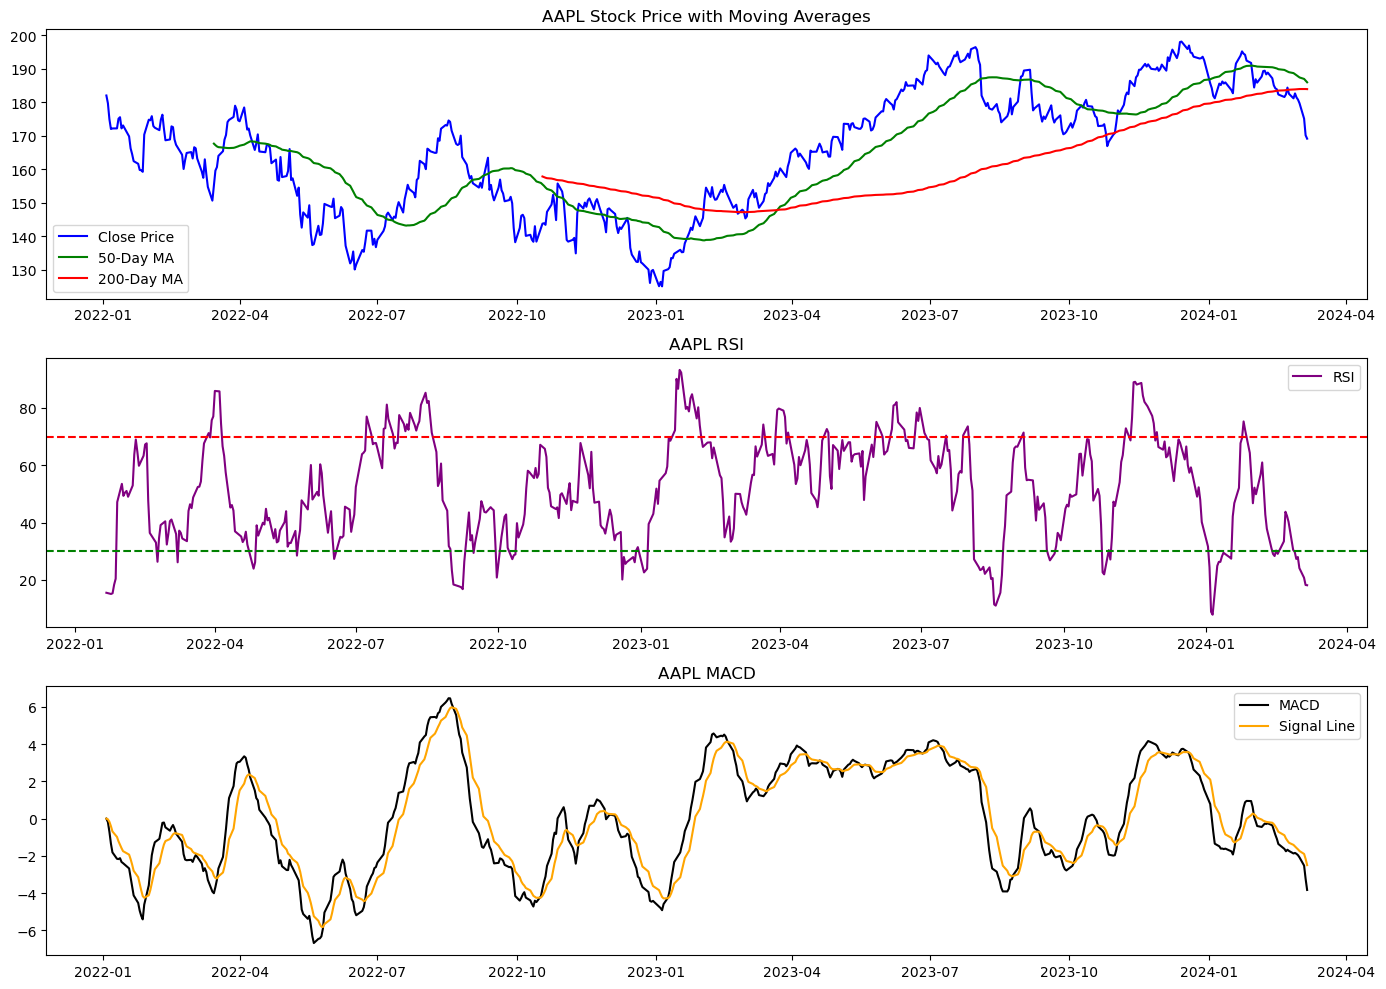

In [15]:
# Define the stock symbol, start date, and end date
symbol = 'AAPL'  # Replace with your desired stock symbol
start_date = '2022-01-01'
end_date = '2024-03-07'
data = fetch_historical_data(symbol, start_date, end_date)
strategy_data = strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(strategy_data['Strategy_Return'], label='AAPL Strategy Returns')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('AAPL Strategy Return')
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(14, 10))

# Plot Closing Price, MA50, and MA200
plt.subplot(311)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA50'], label='50-Day MA', color='green')
plt.plot(data['MA200'], label='200-Day MA', color='red')
plt.title('AAPL Stock Price with Moving Averages')
plt.legend()

# Plot RSI
plt.subplot(312)
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('AAPL RSI')
plt.legend()

# Plot MACD and Signal Line
plt.subplot(313)
plt.plot(data['MACD'], label='MACD', color='black')
plt.plot(data['Signal_Line'], label='Signal Line', color='orange')
plt.title('AAPL MACD')
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

C:\Users\Brendan\AppData\Local\Temp\ipykernel_63000\387516190.py:17: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_return / annualized_volatility


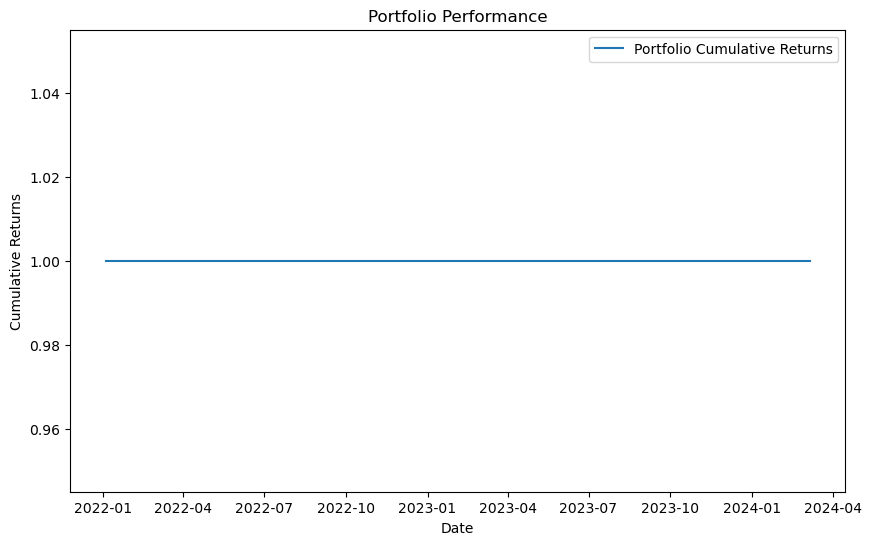

In [4]:
# Define your portfolio
portfolio_tickers = ['SPYG', 'SPEU', 'VLVLY', 'BOTZ', 'RITM',
    "MSFT", "AAPL", "PG", "KO", "JNJ", "PFE",
    "XLK", "IBB", "ICLN", "JPM", "BAC", "XOM", "CVX",
    "EEM", "VGK", "NEE", "DUK", "VZ", "ZBRA", "SAM"
]

start_date = '2022-01-01'
end_date = '2024-3-07'

portfolio_return = portfolio(portfolio_tickers, start_date, end_date)

# Portfolio Metrics
total_return = portfolio_return['Cumulative'].iloc[-1] - 1
annualized_return = portfolio_return['Total'].mean() * 252
annualized_volatility = portfolio_return['Total'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print(f"Total Return: {total_return:.2f}")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plotting the portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(portfolio_return['Cumulative'], label='Portfolio Cumulative Returns')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()